# Plain Crash data harvesting

## Purpose
- This is a simple Python program, which showcases "concurrency" and functional programming aspects of Python language
- Let's say that we want to invest in an airflight carrier, so we want to analyse historical plane crashes
- There is an interesting website, which contains 100 years of historical plane crashes, but it doesn't provide an API, so we will harvest the data using alternative methods
- **Note:** this is not a production quality code. Normally this would be exported to .py file(s), properly documented using doc strings, most likely wrapped in a class(es) with single responsibility methods and much more efficient data processing libraries used (numpy, pandas, etc.)
- **Note2:** we will utilise asyncronous programming paradigm as we will be dealing with slow IO (remote API requests)

## Website info

##### The aviation accident database includes: 

- All civil and commercial aviation accidents of scheduled and non-scheduled passenger airliners worldwide, which resulted in a fatality (including all U.S. Part 121 and Part 135 fatal accidents)
- All cargo, positioning, ferry and test flight fatal accidents. 
- All military transport accidents with 10 or more fatalities.
- All commercial and military helicopter accidents with greater than 10 fatalities.
- All civil and military airship accidents involving fatalities.
- Aviation accidents involving the death of famous people. 
- Aviation accidents or incidents of noteworthy interest.

##### URL: http://www.planecrashinfo.com

##### Raw "interesting" data is in the bottom of the database.htm page:

<img src="year_list.png"/>

In [370]:
from IPython.display import IFrame
IFrame('http://www.planecrashinfo.com/database.htm', width=600, height=300)

##### This page only displays links to years, so our program will need to drill into each year:

In [366]:
IFrame('http://www.planecrashinfo.com/1920/1920.htm', width=600, height=250)

##### Then we can see a list of events with a link again on the left hand side to see the details:

In [369]:
IFrame('http://www.planecrashinfo.com/1920/1920-1.htm', width=400, height=250)

##### This is exactly the data we want to capture

## Retrieve data and save to csv

In [14]:
# install libs if necessary, my Docker py-spark image did not have those by default
# !pip install asyncio
# !pip install aiohttp
# !pip install aiofiles
# !pip install nest_asyncio

In [213]:
# import libs
import asyncio
import aiofiles
import aiohttp
from bs4 import BeautifulSoup
import re
import csv

In [16]:
# this is needed to get asyncio to work with Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

# this will keep the Notebook bit cleaner
from IPython.display import clear_output

In [17]:
# define handy function to asyncrounously call API end-points
async def async_http(base_url, endpoint=''):
    async with aiohttp.ClientSession() as session:
        abs_url = f'{base_url}/{endpoint}'
        async with session.get(abs_url, headers=HEADERS) as resp:
            if resp.status == 200:
                data = await resp.text()
                return data

In [18]:
# define global variables for API calls, sometimes it's good to switch 
# between the user agents to simulate different users
# (Catch: be careful if your IP address is still the same though :] )
base_url = 'http://www.planecrashinfo.com'
HEADERS = {
    'user-agent': ('Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) '
                   'AppleWebKit/537.36 (KHTML, like Gecko) '
                   'Chrome/45.0.2454.101 Safari/537.36'),
}

##### Retrieve links to sub-pages

In [26]:
# initiate asyncio loop
loop = asyncio.get_event_loop()

# retrieve html and create soup object
html = loop.run_until_complete(async_http(base_url, '/database.htm'))

# create re-usable function to extract the href's from html content
def extract_html_links(html, html_table_id=0):
    return [l for l in BeautifulSoup(html, 'html5lib').findAll(
        'table')[html_table_id].select('td a[href]')]

# Extract links to sub-pages using B-Soup API,
# based on HTML - we need to grab a second table,
# and within this table, we will get cells and anchor tags,
# their href attribute will define a link to the sub-page.
# Unforunately tables don't have any id's or classes,
# so there is a chance that this code will fail if they
# decide to change tables in their HTML
links = extract_html_links(html, 1)

##### Retrieve data from sub-pages

**Sync or Async ???** Before we start the heavy duty stuff, let's run a quick test to compare the speed of retrieving URLs with and without acyncio

In [22]:
%%time
# syncronous
import requests
for l in links[:10]:
    text = requests.get(f'{base_url}/{l}').text

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 5.52 s


In [23]:
%%time
# asyncronous
sub_pages = loop.run_until_complete(asyncio.gather(*(async_http(base_url, l) for l in links[:10])))

CPU times: user 2.23 s, sys: 30 ms, total: 2.26 s
Wall time: 2.77 s


##### Conclusion:
- Async was almost 2+ times faster (in some tests it was 4+ times faster) for 10 requests and this differnt will grow with more requests excuted
- We will stick to async from now on as it will be much more efficient (unless we like to meditate while requests are being processed)

In [24]:
# get all sub-pages HTML,
# each will represent a single year
sub_pages = loop.run_until_complete(asyncio.gather(*(async_http(base_url, l) for l in links)))

In [48]:
# get all the links for each year
links_by_year = [extract_html_links(sp) for sp in sub_pages]

In [37]:
# define a function to retrieve multiple HTML contents
# in async fashion for each link defined as an argument
def get_html_contents(links):
    return loop.run_until_complete(asyncio.gather(*(
        async_http(base_url, l[:4] + '/' + l) for l in links)))

In [ ]:
# grab content for all the links in each year,
# this list will be huge so normally we would process
# chunks on the fly instead of filling the RAM
content_by_year = [get_html_contents(l) for l in links_by_year]

In [169]:
# extract tr tags from table in HTML
def extract_crash_info_rows(html):
    return [el for el in BeautifulSoup(html, 'html5lib').findAll('table')[0].select('tr')]

In [170]:
# extract data element pairs from B-Soup tr tag
def extract_tr(row):
    return re.findall(u'<b>([a-zA-Z#// \s]+):<\/b>.+<font.+>(.+)<\/font>', str(row.contents))

In [227]:
# define simple annonymous function to clean up strings,
# ended up not using it as it sticks in b' in the csv,
# but might be handy to keep it
clean_up_str = lambda x: x.encode('utf-8').strip()

In [315]:
# process crash html, for now we are ok if 
# we can not extract a single crash here and there,
# normally we would investigate and fix the issue
def process_crash_html(crash_html):
    try:
        return [extract_tr(row)[0][1] for row in extract_crash_info_rows(crash_html)[1:]]
    except Exception as e:
        return None

In [316]:
# main execution body
def main():

    # define output file and csv writer
    output_file = open('output_2Feb2018.csv', 'w', encoding='utf8')
    csv_writer = csv.writer(output_file)

    # save initial headers into the file
    csv_writer.writerow(['Date', 'Time', 'Location', 'Operator', 'Flight',
                        'Route', 'AC_Type', 'Registration', 'cn_ln', 'Aboard',
                        'Fatalities', 'Ground', 'Summary'])

    # save to csv in batches
    for yc in content_by_year:
        rows = [process_crash_html(crash_html) for crash_html in yc]
        
        # make sure that we filter out None records as these cause problems for csv writer
        csv_writer.writerows(list(filter(lambda x: x is not None, rows)))

main()

#### Done
Processing is completed and we have a csv file, which can be used further by data scientists or ourselves to dive deeper into the data-set.

## Analysis
- Now that the data is ready in the csv file, we can start investigating it using either statistical libraries or by putting together a UI around it (Tableau or web)
- Usually drawing a few plots makes things very clear
- As an example - let's calculate a count of accidents per year and then visualise it
- There is much more interesting stuff we could do with this data, but unfortunately I am running out of time at this stage...

In [346]:
# define any imports here
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [321]:
# read-in csv file, and skip the file header
with open('output_2Feb2018.csv') as myFile:
    rows = [r for i, r in enumerate(csv.reader(myFile)) if i > 0]

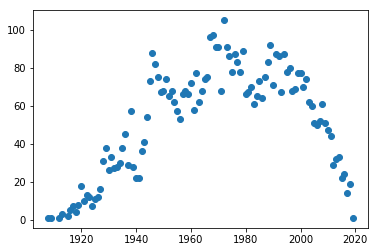

In [350]:
# grab year by taking last 4 characters from each row and count instances
crashes_by_year = dict(Counter([int(r[0][-4:]) for r in rows]))

# plot data using matplotlib
plt.scatter(x=list(crashes_by_year.keys()), y=list(crashes_by_year.values()));

#### Eureka:
We might be actually in a good place, number of crashes is going down, while it peaked around the 80's

## Conclusion
- We were able to successfully process almost 6000 rows of data from a website
- This was not actually a very challenging task, but it was simple and allowed us to show-case cool Python techniques to obtain data, which is not available otherwise
- Sometimes this is not good enough and we need to be more clever, for example server might block us for executing too many requests or data from the same IP address
- Some websites need advanced JavaScript events (like scrolling, clicking, waiting for output, hovering, etc.) - and in those scenarios I would recommend to look at Node's excellent **nightmare** library
- Last but not least: all this is only an information, we should always consult the robots.txt file on a particular website and read the terms and conditions
- And the very last - **respect personal data**. With power comes responsibility!